<a href="https://colab.research.google.com/github/msanezary/MultiMNIST-classification/blob/main/Cassiopp%C3%A9e_MultiMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the dataset
with open('multi_mnist.pickle', 'rb') as file:
    dataset = pickle.load(file)

Shape of the first image: (36, 36)


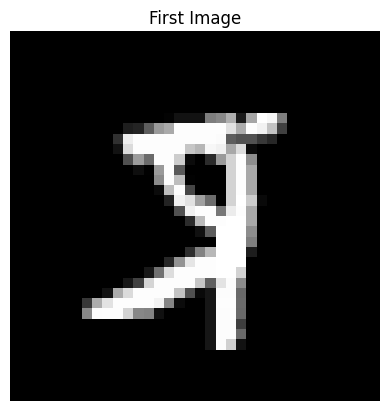

In [ ]:
# Directly access and display the first image in the dataset to troubleshoot
first_image = dataset[0][0]  # Assuming the first element of the first tuple is the image

print(f'Shape of the first image: {first_image.shape}')  # Should print (36, 36)

plt.imshow(first_image, cmap='gray')
plt.title('First Image')
plt.axis('off')
plt.show()

In [ ]:
# Function to inspect the dataset
def inspect_dataset_structure(dataset):
    for i, element in enumerate(dataset):
        print(f'Element {i}:', type(element))
        # Check if the element is a list or ndarray and print its length or shape
        if isinstance(element, list):
            print('Type of element:', type(element), 'Length:', len(element))
        elif isinstance(element, np.ndarray):
            print('Type of element:', type(element), 'Shape:', element.shape)
        else:
            print('Element is neither list nor ndarray. Type:', type(element))

        # If the element is a list or ndarray, look deeper into its first item
        if isinstance(element, (list, np.ndarray)) and len(element) > 0:
            first_item = element[0]
            print('Type of first item in element:', type(first_item))
            if isinstance(first_item, np.ndarray):
                print('Shape of first item in element:', first_item.shape)
            else:
                print('Content of first item in element:', first_item)

        # Print a separator for readability
        print('-' * 50)

# Assuming 'dataset' is a variable holding your loaded dataset
inspect_dataset_structure(dataset)

Element 0: <class 'numpy.ndarray'>
Type of element: <class 'numpy.ndarray'> Shape: (120000, 36, 36)
Type of first item in element: <class 'numpy.ndarray'>
Shape of first item in element: (36, 36)
--------------------------------------------------
Element 1: <class 'numpy.ndarray'>
Type of element: <class 'numpy.ndarray'> Shape: (120000, 2)
Type of first item in element: <class 'numpy.ndarray'>
Shape of first item in element: (2,)
--------------------------------------------------
Element 2: <class 'numpy.ndarray'>
Type of element: <class 'numpy.ndarray'> Shape: (20000, 36, 36)
Type of first item in element: <class 'numpy.ndarray'>
Shape of first item in element: (36, 36)
--------------------------------------------------
Element 3: <class 'numpy.ndarray'>
Type of element: <class 'numpy.ndarray'> Shape: (20000, 2)
Type of first item in element: <class 'numpy.ndarray'>
Shape of first item in element: (2,)
--------------------------------------------------


In [ ]:
def show_images_and_labels(images, labels, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Adjust as necessary for num_images
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= num_images:
            break  # Stop if we've reached the desired number of images
        image = images[i].reshape(36, 36)  # Reshape if necessary
        label = labels[i]  # Get the corresponding labels

        ax.imshow(image, cmap='gray')
        ax.set_title(f'Top-Left: {label[0]}, Bottom-Right: {label[1]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Using the shapes provided to slice the dataset correctly
# The first element (images) should be reshaped into individual images if necessary
# The second element (labels) contains the labels corresponding to the images
images = dataset[0].reshape(-1, 36, 36)  # Reshape the images for visualization if they are not already in this shape
labels = dataset[1]  # Labels are already in the correct shape

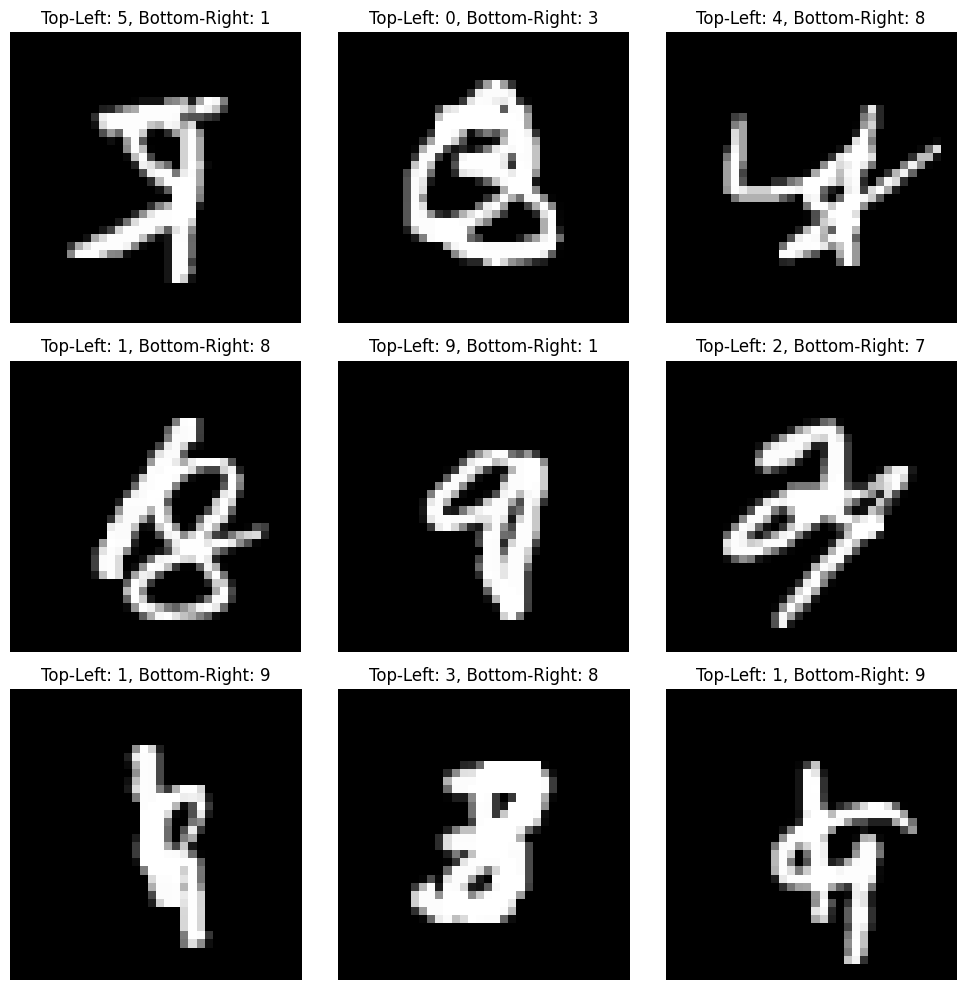

In [ ]:
show_images_and_labels(images, labels, num_images=9)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize

In [ ]:
# Define a transformation to normalize the data
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1] assuming the data is in range [0, 255]
])

# Assuming `dataset` is a list with 4 elements: train_images, train_labels, test_images, test_labels
train_images_np = dataset[0].reshape(-1, 36, 36).astype('float32') / 255.0
train_labels_np = dataset[1]
test_images_np = dataset[2].reshape(-1, 36, 36).astype('float32') / 255.0
test_labels_np = dataset[3]

In [ ]:
# Apply the transformation and convert to tensors
train_images = torch.stack([transform(img) for img in train_images_np])
train_labels = torch.tensor(train_labels_np, dtype=torch.long)
test_images = torch.stack([transform(img) for img in test_images_np])
test_labels = torch.tensor(test_labels_np, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)


In [ ]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.optim as optim


In [ ]:
from typing import List

In [ ]:
class LeNetHyper(nn.Module):
    """LeNet Hypernetwork"""

    def __init__(
        self,
        kernel_size: List[int],
        ray_hidden_dim=100,
        out_dim=10,
        target_hidden_dim=50,
        n_kernels=10,
        n_conv_layers=2,
        n_hidden=1,
        n_tasks=2,
    ):
        super().__init__()
        self.n_conv_layers = n_conv_layers
        self.n_hidden = n_hidden
        self.n_tasks = n_tasks

        assert len(kernel_size) == n_conv_layers, (
            "kernel_size is list with same dim as number of "
            "conv layers holding kernel size for each conv layer"
        )

        self.ray_mlp = nn.Sequential(
            nn.Linear(2, ray_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(ray_hidden_dim, ray_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(ray_hidden_dim, ray_hidden_dim),
        )

        self.conv_0_weights = nn.Linear(
            ray_hidden_dim, n_kernels * kernel_size[0] * kernel_size[0]
        )
        self.conv_0_bias = nn.Linear(ray_hidden_dim, n_kernels)

        for i in range(1, n_conv_layers):
            # previous number of kernels
            p = 2 ** (i - 1) * n_kernels
            # current number of kernels
            c = 2 ** i * n_kernels

            setattr(
                self,
                f"conv_{i}_weights",
                nn.Linear(ray_hidden_dim, c * p * kernel_size[i] * kernel_size[i]),
            )
            setattr(self, f"conv_{i}_bias", nn.Linear(ray_hidden_dim, c))

        latent = 25
        self.hidden_0_weights = nn.Linear(
            ray_hidden_dim, target_hidden_dim * 2 ** i * n_kernels * latent
        )
        self.hidden_0_bias = nn.Linear(ray_hidden_dim, target_hidden_dim)

        for j in range(n_tasks):
            setattr(
                self,
                f"task_{j}_weights",
                nn.Linear(ray_hidden_dim, target_hidden_dim * out_dim),
            )
            setattr(self, f"task_{j}_bias", nn.Linear(ray_hidden_dim, out_dim))

    def shared_parameters(self):
        return list([p for n, p in self.named_parameters() if "task" not in n])

    def forward(self, ray):
        features = self.ray_mlp(ray)

        out_dict = {}
        layer_types = ["conv", "hidden", "task"]

        for i in layer_types:
            if i == "conv":
                n_layers = self.n_conv_layers
            elif i == "hidden":
                n_layers = self.n_hidden
            elif i == "task":
                n_layers = self.n_tasks

            for j in range(n_layers):
                out_dict[f"{i}{j}.weights"] = getattr(self, f"{i}_{j}_weights")(
                    features
                )
                out_dict[f"{i}{j}.bias"] = getattr(self, f"{i}_{j}_bias")(
                    features
                ).flatten()

        return out_dict



In [ ]:
import torch.nn.functional as F

In [ ]:
class LeNetTarget(nn.Module):
    """LeNet target network"""

    def __init__(
        self,
        kernel_size,
        n_kernels=10,
        out_dim=10,
        target_hidden_dim=50,
        n_conv_layers=2,
        n_tasks=2,
    ):
        super().__init__()
        assert len(kernel_size) == n_conv_layers, (
            "kernel_size is list with same dim as number of "
            "conv layers holding kernel size for each conv layer"
        )
        self.n_kernels = n_kernels
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        self.n_conv_layers = n_conv_layers
        self.n_tasks = n_tasks
        self.target_hidden_dim = target_hidden_dim

    def forward(self, x, weights=None):
        x = F.conv2d(
            x,
            weight=weights["conv0.weights"].reshape(
                self.n_kernels, 1, self.kernel_size[0], self.kernel_size[0]
            ),
            bias=weights["conv0.bias"],
            stride=1,
        )
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        for i in range(1, self.n_conv_layers):
            x = F.conv2d(
                x,
                weight=weights[f"conv{i}.weights"].reshape(
                    int(2 ** i * self.n_kernels),
                    int(2 ** (i - 1) * self.n_kernels),
                    self.kernel_size[i],
                    self.kernel_size[i],
                ),
                bias=weights[f"conv{i}.bias"],
                stride=1,
            )
            x = F.relu(x)
            x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.linear(
            x,
            weight=weights["hidden0.weights"].reshape(
                self.target_hidden_dim, x.shape[-1]
            ),
            bias=weights["hidden0.bias"],
        )

        logits = []
        for j in range(self.n_tasks):
            logits.append(
                F.linear(
                    x,
                    weight=weights[f"task{j}.weights"].reshape(
                        self.out_dim, self.target_hidden_dim
                    ),
                    bias=weights[f"task{j}.bias"],
                )
            )
        return logits

In [ ]:
def circle_points(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = 1e-6 if min_angle is None else min_angle
    ang1 = np.pi / 2 - ang0 if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import logging

In [ ]:
def set_logger():
    logging.basicConfig(
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
        level=logging.INFO,
    )


In [ ]:
from collections import defaultdict

In [ ]:
@torch.no_grad()
def evaluate(hypernet, targetnet, loader, rays):
    hypernet.eval()
    loss1 = nn.CrossEntropyLoss()
    loss2 = nn.CrossEntropyLoss()

    results = defaultdict(list)

    for ray in rays:
        total = 0.0
        task1_correct, task2_correct = 0.0, 0.0
        l1, l2 = 0.0, 0.0
        ray = torch.from_numpy(ray.astype(np.float32))
        ray /= ray.sum()

        for batch in loader:
            hypernet.zero_grad()

            batch = (t for t in batch)
            img, ys = batch
            bs = len(ys)

            weights = hypernet(ray)
            logit1, logit2 = targetnet(img, weights)

            # loss
            curr_l1 = loss1(logit1, ys[:, 0])
            curr_l2 = loss2(logit2, ys[:, 1])
            l1 += curr_l1 * bs
            l2 += curr_l2 * bs

            # acc
            pred1 = logit1.data.max(1)[1]  # first column has actual prob.
            pred2 = logit2.data.max(1)[1]  # first column has actual prob.
            task1_correct += pred1.eq(ys[:, 0]).sum()
            task2_correct += pred2.eq(ys[:, 1]).sum()

            total += bs

        results["ray"].append(ray.squeeze(0).numpy().tolist())
        results["task1_acc"].append(task1_correct.item() / total)
        results["task2_acc"].append(task2_correct.item() / total)
        results["task1_loss"].append(l1.item() / total)
        results["task2_loss"].append(l2.item() / total)

    return results


In [ ]:
from abc import abstractmethod

In [ ]:
class Solver:
    def __init__(self, n_tasks):
        super().__init__()
        self.n_tasks = n_tasks

    @abstractmethod
    def get_weighted_loss(self, losses, ray, parameters=None, **kwargs):
        pass

    def __call__(self, losses, ray, parameters, **kwargs):
        return self.get_weighted_loss(losses, ray, parameters, **kwargs)


class LinearScalarizationSolver(Solver):
    """For LS we use the preference ray to weigh the losses"""

    def __init__(self, n_tasks):
        super().__init__(n_tasks)

    def get_weighted_loss(self, losses, ray, parameters=None, **kwargs):
        return (losses * ray).sum()

In [ ]:
from tqdm import trange

In [ ]:
from pathlib import Path

In [ ]:
import json

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
class Dataset:
    def __init__(self, path, val_size=0):
        self.path = path
        self.val_size = val_size

    def get_datasets(self):
        with open(self.path, "rb") as f:
            trainX, trainLabel, testX, testLabel = pickle.load(f)

        n_train = len(trainX)
        if self.val_size > 0:
            trainX, valX, trainLabel, valLabel = train_test_split(
                trainX, trainLabel, test_size=self.val_size, random_state=42
            )
            n_train = len(trainX)
            n_val = len(valX)

        trainX = torch.from_numpy(trainX.reshape(n_train, 1, 36, 36)).float()
        trainLabel = torch.from_numpy(trainLabel).long()
        testX = torch.from_numpy(testX.reshape(20000, 1, 36, 36)).float()
        testLabel = torch.from_numpy(testLabel).long()

        train_set = torch.utils.data.TensorDataset(trainX, trainLabel)
        test_set = torch.utils.data.TensorDataset(testX, testLabel)

        if self.val_size > 0:
            valX = torch.from_numpy(valX.reshape(n_val, 1, 36, 36)).float()
            valLabel = torch.from_numpy(valLabel).long()
            val_set = torch.utils.data.TensorDataset(valX, valLabel)

            return train_set, val_set, test_set

        return train_set, test_set

In [ ]:
def train(
    path,
    solver_type: str,
    epochs: int,
    hidden_dim: int,
    model: str,
    lr: float,
    wd: float,
    bs: int,
    val_size: float,
    n_rays: int,
    alpha: float,
    no_val_eval: bool,
    out_dir: str,
    eval_every: int,

) -> None:
    # ----
    # Nets
    # ----
    hnet: nn.Module = LeNetHyper([9, 5], ray_hidden_dim=hidden_dim)
    net: nn.Module = LeNetTarget([9, 5])


    logging.info(f"HN size: {count_parameters(hnet)}")

    hnet = hnet
    net = net

    # ---------
    # Task loss
    # ---------
    loss1 = nn.CrossEntropyLoss()
    loss2 = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(hnet.parameters(), lr=lr, weight_decay=wd)

    # ------
    # solver
    # ------
    solvers = dict(ls=LinearScalarizationSolver)

    solver_method = solvers[solver_type]

        # ls
    solver = solver_method(n_tasks=2)

    # ----
    # data
    # ----
    assert val_size > 0, "please use validation by providing val_size > 0"
    data = Dataset(path, val_size=val_size)
    train_set, val_set, test_set = data.get_datasets()

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=bs, shuffle=True, num_workers=4
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_set, batch_size=bs, shuffle=True, num_workers=4
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=bs, shuffle=False, num_workers=4
    )

    min_angle = 0.1
    max_angle = np.pi / 2 - 0.1
    test_rays = circle_points(n_rays, min_angle=min_angle, max_angle=max_angle)

    # ----------
    # Train loop
    # ----------
    last_eval = -1
    epoch_iter = trange(epochs)

    val_results = dict()
    test_results = dict()

    for epoch in epoch_iter:

        for i, batch in enumerate(train_loader):
            hnet.train()
            optimizer.zero_grad()
            img, ys = batch


            if alpha > 0:
                ray = torch.from_numpy(
                    np.random.dirichlet((alpha, alpha), 1).astype(np.float32).flatten()
                )
            else:
                alpha = torch.empty(
                    1,
                ).uniform_(0.0, 1.0)
                ray = torch.tensor([alpha.item(), 1 - alpha.item()])

            weights = hnet(ray)
            logit1, logit2 = net(img, weights)

            l1 = loss1(logit1, ys[:, 0])
            l2 = loss2(logit2, ys[:, 1])
            losses = torch.stack((l1, l2))

            ray = ray.squeeze(0)
            loss = solver(losses, ray, list(hnet.parameters()))

            loss.backward()

            epoch_iter.set_description(
                f"total weighted loss: {loss.item():.3f}, loss 1: {l1.item():.3f}, loss 2: {l2.item():.3f}"
                # f", ray {ray.cpu().numpy().tolist()}"
            )

            optimizer.step()

        if (epoch + 1) % eval_every == 0:
            last_eval = epoch
            if not no_val_eval:
                epoch_results = evaluate(
                    hypernet=hnet,
                    targetnet=net,
                    loader=val_loader,
                    rays=test_rays,

                )
                val_results[f"epoch_{epoch + 1}"] = epoch_results

            test_epoch_results = evaluate(
                hypernet=hnet,
                targetnet=net,
                loader=test_loader,
                rays=test_rays,

            )
            test_results[f"epoch_{epoch + 1}"] = test_epoch_results

    if epoch != last_eval:
        if not no_val_eval:
            epoch_results = evaluate(
                hypernet=hnet,
                targetnet=net,
                loader=val_loader,
                rays=test_rays,

            )
            val_results[f"epoch_{epoch + 1}"] = epoch_results

        test_epoch_results = evaluate(
            hypernet=hnet,
            targetnet=net,
            loader=test_loader,
            rays=test_rays,

        )
        test_results[f"epoch_{epoch + 1}"] = test_epoch_results

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    with open(Path(out_dir) / "val_results.json", "w") as file:
        json.dump(val_results, file)
    with open(Path(out_dir) / "test_results.json", "w") as file:
        json.dump(test_results, file)


In [ ]:
import argparse

In [ ]:
import random

In [ ]:
def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)

In [ ]:
def save_args(folder, args, name="config.json", check_exists=False):
    set_logger()
    path = Path(folder)
    if check_exists:
        if path.exists():
            logging.warning(f"folder {folder} already exists! old files might be lost.")
    path.mkdir(parents=True, exist_ok=True)

    json.dump(vars(args), open(path / name, "w"))

In [ ]:
set_seed(42)

set_logger()

train(
        path="multi_mnist.pickle",
        solver_type="ls",
        epochs=150,
        hidden_dim=100,
        model="lenet",
        lr=1e-4,
        wd=0.0,
        bs=256,

        eval_every=10,
        no_val_eval=False,
        val_size=0.1,
        n_rays=25,
        alpha=0.2,
        out_dir="outputs",
    )



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total weighted loss: 0.296, loss 1: 0.281, loss 2: 0.296:  39%|███▊      | 58/150 [1:27:03<2:18:05, 90.06s/it]


KeyboardInterrupt: 

In [ ]:
# Define the Multi-task CNN
class MultiTaskCNN(nn.Module):
    def __init__(self):
        super(MultiTaskCNN, self).__init__()
        # Shared layers
        self.conv_base = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(32 * 18 * 18, 128)

        # Task-specific layers
        self.fc_top_left = nn.Linear(128, 10)
        self.fc_bottom_right = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        top_left_output = self.fc_top_left(x)
        bottom_right_output = self.fc_bottom_right(x)
        return top_left_output, bottom_right_output


In [ ]:
# Initialize the model, loss functions, and optimizer
model = MultiTaskCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch_images, batch_labels in train_loader:
        # Split the labels for each digit
        top_left_labels = batch_labels[:, 0]
        bottom_right_labels = batch_labels[:, 1]

        # Forward pass
        top_left_pred, bottom_right_pred = model(batch_images)
        loss_top_left = criterion(top_left_pred, top_left_labels)
        loss_bottom_right = criterion(bottom_right_pred, bottom_right_labels)

        # Combine losses
        loss = loss_top_left + loss_bottom_right
        running_loss += loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(train_loader)

    # Print the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    # Validation step (if desired)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Initialize variable to calculate validation loss
        val_loss = 0.0
        # Iterate over the validation set
        for val_images, val_labels in test_loader:
            # Split the labels
            top_left_labels = val_labels[:, 0]
            bottom_right_labels = val_labels[:, 1]

            # Forward pass
            top_left_pred, bottom_right_pred = model(val_images)
            loss_top_left = criterion(top_left_pred, top_left_labels)
            loss_bottom_right = criterion(bottom_right_pred, bottom_right_labels)

            # Combine losses
            loss = loss_top_left + loss_bottom_right
            val_loss += loss.item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(test_loader)
        print(f'Validation Loss: {avg_val_loss:.4f}')

Epoch [1/10], Loss: 0.4045
Validation Loss: 0.8108
Epoch [2/10], Loss: 0.3857
Validation Loss: 0.8413
Epoch [3/10], Loss: 0.3685
Validation Loss: 0.8612
Epoch [4/10], Loss: 0.3559
Validation Loss: 0.8860
Epoch [5/10], Loss: 0.3411
Validation Loss: 0.9153
Epoch [6/10], Loss: 0.3290
Validation Loss: 0.9632
Epoch [7/10], Loss: 0.3187
Validation Loss: 0.9798
Epoch [8/10], Loss: 0.3093
Validation Loss: 1.0023
Epoch [9/10], Loss: 0.3016
Validation Loss: 1.0187
Epoch [10/10], Loss: 0.2895
Validation Loss: 1.0482
